# FICO Score Bucketing Optimization

Objective: Convert raw FICO scores into graded ratings to optimize risk segmentation.

Methods: Dynamic Programming, Log-Likelihood Maximization.

In [1]:
import pandas as pd
import numpy as np

# Load the data (assuming you still have 'loan_data.csv')
df = pd.read_csv('loan_data.csv')

# 1. Aggregate the data by FICO Score
# We want to know: For FICO 600, how many total loans? How many defaults?
x = df.groupby('fico_score')['default'].agg(['count', 'sum']).reset_index()
x.columns = ['fico_score', 'total', 'defaults']
x = x.sort_values('fico_score')

# 2. Add 'non-defaults' for easier calculation
x['non_defaults'] = x['total'] - x['defaults']

print(f"Data condensed from {len(df)} rows to {len(x)} unique FICO scores.")
print(x.head())

Data condensed from 10000 rows to 374 unique FICO scores.
   fico_score  total  defaults  non_defaults
0         408      1         0             1
1         409      1         1             0
2         418      1         1             0
3         425      1         1             0
4         438      1         1             0


In [2]:
def log_likelihood(n, k):
    """
    Calculates the log-likelihood of a bucket.
    n: total number of records in the bucket
    k: number of defaults in the bucket
    """
    p = k / n
    if p == 0 or p == 1:
        return 0  # Perfect purity (all default or all non-default) has 0 entropy cost
    
    # Formula: k * ln(p) + (n-k) * ln(1-p)
    return k * np.log(p) + (n - k) * np.log(1 - p)

In [3]:
def optimize_buckets(df_agg, num_buckets):
    # Retrieve the arrays from our aggregated dataframe
    totals = df_agg['total'].values
    defaults = df_agg['defaults'].values
    n_points = len(totals)
    
    # DP Matrix: dp[k][i] stores the best log-likelihood for k buckets covering the first i points
    # We initialize with negative infinity because we want to MAXIMIZE the score
    dp = np.full((num_buckets + 1, n_points + 1), -np.inf)
    
    # Backtracking Matrix: to remember WHERE we made the cuts
    boundaries = np.zeros((num_buckets + 1, n_points + 1), dtype=int)
    
    # Base Case: 0 buckets for 0 points is 0 score
    dp[0][0] = 0
    
    # Iterate through each bucket count (1 bucket, then 2 buckets, etc.)
    for k in range(1, num_buckets + 1):
        # Iterate through each possible end point of the data
        for i in range(1, n_points + 1):
            
            # Optimization: We don't need to check cuts way back at the start 
            # if we have many buckets left to fill.
            # But for simplicity, we iterate j from 0 to i
            for j in range(i):
                # 'j' is the potential cut point.
                # New bucket is from j to i.
                # Previous solution is dp[k-1][j]
                
                # 1. Calculate stats for this new bucket (j to i)
                bucket_total = np.sum(totals[j:i])
                bucket_defaults = np.sum(defaults[j:i])
                
                # 2. Calculate Score
                if bucket_total > 0:
                    score = log_likelihood(bucket_total, bucket_defaults)
                    
                    # 3. Transition: Is this better than what we found before?
                    prev_score = dp[k-1][j]
                    if prev_score + score > dp[k][i]:
                        dp[k][i] = prev_score + score
                        boundaries[k][i] = j
                        
    # Reconstruct the solution (Backtracking)
    cuts = []
    curr_idx = n_points
    for k in range(num_buckets, 0, -1):
        prev_idx = boundaries[k][curr_idx]
        cuts.append(prev_idx)
        curr_idx = prev_idx
        
    # The 'cuts' are indices in the aggregated array. We need the actual FICO scores.
    cuts = sorted(cuts)
    fico_boundaries = []
    for idx in cuts:
        if idx < n_points:
            fico_boundaries.append(df_agg.iloc[idx]['fico_score'])
        else:
            fico_boundaries.append(850) # The last bucket ends at max
            
    return fico_boundaries

# --- EXECUTE THE OPTIMIZATION ---
# Let's ask for 10 buckets (Ratings 1-10)
final_boundaries = optimize_buckets(x, 10)
print("Optimal FICO Bucket Boundaries:", final_boundaries)

Optimal FICO Bucket Boundaries: [408, 521, 553, 581, 612, 650, 697, 733, 753, 754]


FICO 800 -> Rating 1 (Should be 1)
FICO 620 -> Rating 6 (Should be mid-range)
FICO 400 -> Rating 10 (Should be 10)

--- Default Rate by Rating ---
   Rating  Default_Rate
0       1      0.021097
1       2      0.000000
2       3      0.027491
3       4      0.058934
4       5      0.096488
5       6      0.161460
6       7      0.241619
7       8      0.330159
8       9      0.454000
9      10      0.651899


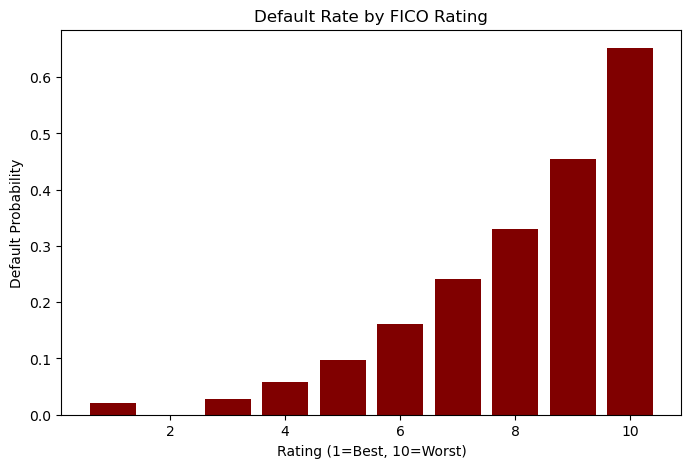

In [4]:
class FicoRatingMapper:
    def __init__(self, boundaries):
        """
        boundaries: The list of FICO scores generated by the optimization algorithm.
        Example: [408, 521, 553, ...]
        """
        # We ensure the boundaries are sorted just in case
        self.boundaries = sorted(boundaries)
        
    def get_rating(self, fico_score):
        """
        Maps a FICO score to a Rating (1 to 10).
        Rating 1 = Best Credit (High Score)
        Rating 10 = Worst Credit (Low Score)
        """
        # If score is lower than the lowest boundary, it's the worst rating
        if fico_score <= self.boundaries[0]:
            return 10
            
        # Check which bucket the score falls into
        # We start checking from the highest boundary downwards
        # because higher score = better rating (lower number)
        num_buckets = len(self.boundaries)
        
        for i in range(num_buckets - 1, 0, -1):
            if fico_score > self.boundaries[i]:
                # If we have 10 boundaries, the highest bucket is Rating 1
                # The second highest is Rating 2, etc.
                # Logic: If boundaries length is 10, i goes 9, 8...
                # If score > boundaries[9] (754), return 1
                return num_buckets - i
        
        # If it didn't return yet, it falls in the lowest bucket above the min
        return num_buckets

# --- VERIFICATION ---
# 1. Initialize the mapper with YOUR calculated boundaries
boundaries = [408, 521, 553, 581, 612, 650, 697, 733, 753, 754]
rating_mapper = FicoRatingMapper(boundaries)

# 2. Test a few scores
print(f"FICO 800 -> Rating {rating_mapper.get_rating(800)} (Should be 1)")
print(f"FICO 620 -> Rating {rating_mapper.get_rating(620)} (Should be mid-range)")
print(f"FICO 400 -> Rating {rating_mapper.get_rating(400)} (Should be 10)")

# 3. Analyze the Buckets (Optional but recommended)
# Let's check the Default Rate for each Rating to make sure it makes sense
df['Rating'] = df['fico_score'].apply(rating_mapper.get_rating)

print("\n--- Default Rate by Rating ---")
analysis = df.groupby('Rating')['default'].mean().reset_index()
analysis.columns = ['Rating', 'Default_Rate']
print(analysis)

# Plot it to visualize the trend
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 5))
plt.bar(analysis['Rating'], analysis['Default_Rate'], color='maroon')
plt.xlabel('Rating (1=Best, 10=Worst)')
plt.ylabel('Default Probability')
plt.title('Default Rate by FICO Rating')
plt.show()